# CSC/XMM validation catalogs, XMM/CSC hostless catalog

In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
# plt.style.use('seaborn')

import seaborn as sns

from scripts.utils import set_mpl, data_path
from scripts.cross_match_scripts import cross_match_data_frames,  add_separation_columns
set_mpl()

%matplotlib inline
from astropy.table import Table

matplotlib settings set


matplotlib settings set
matplotlib settings set


In [3]:
def csc_error_converter(df: pd.DataFrame,
                        r0_colname='err_ellipse_r0',
                        r1_colname='err_ellipse_r1') -> pd.DataFrame:
    """
    The function converts default radii `r0_colname`
    and `r1_colname` to the one-sigma error.

    Args:
        df (pd.DataFrame): DataFrame with `r0_colname` and
        `r1_colname` columns.
        
        r0_colname (str): major radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r0'.
        
        r1_colname (str): minor radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r1'.

    Returns:
        pd.DataFrame: one-sigma error in arcseconds.
    """

    # Conversion coefficient
    csc_sigma_coeff = np.sqrt(-(1 / (2 * np.log(1 - .95))))

    err_r1 = df[r0_colname]
    err_r2 = df[r1_colname]
    # Effective error
    csc_err_eff = np.sqrt(err_r1 ** 2 + err_r2 ** 2)

    csc_1sigma = csc_sigma_coeff * csc_err_eff

    return csc_1sigma


def vot2pd_csc(csc_cat_path: str,
               colnames: list,
               save_coords: bool = False, 
               radec_fits_name: str = 'cscresults_name_radec') -> pd.DataFrame:
    """
    The function converts the votable file to pandas DataFrame.

    Optionally saves the separate file with the coordinates and names of
    the CSC sources to the FITS file.

    Args:
        csc_cat_path (str): the path to the votable file.
        colnames (list): column names of the votable file.
        save_coords (bool): if True, saves the separate file with the coordinates
        and names of the CSC sources to the FITS file.
        radec_fits_name (str): name of the FITS file with
        the coordinates and names of the CSC sources to be saved.

    Returns:
        pd.DataFrame: converted catalogue.
    """
    
    vot_table = Table.read(csc_cat_path, format='votable')
    
    df = vot_table.to_pandas()
    df.columns = colnames

    df = df.assign(flux_csc_05_2 = lambda x: x.flux_aper_s + x.flux_aper_m)

    one_sigma_errors = csc_error_converter(df)

    df = df.assign(radec_err_csc = one_sigma_errors)

    df['r_98_csc'] = tsource_r(sigma=df['radec_err_csc'], t_thresh=.02)

    if save_coords:

        df_init_coords = df[['name', 'ra', 'dec']]
        Table.from_pandas(df_init_coords).write(f'data/{radec_fits_name}.fits', format='fits')

    return df


def tsource_r(sigma: float, t_thresh: float) -> float:
    """
    Calculates the radius of circle which contains the probability `t_thresh`
    NOT to find a counterpart for a source with localization error `sigma`.

    Args:
        sigma (float): localization error in arcsec.
        t_thresh (float): probability to NOT find a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    rsearch = sigma * np.sqrt(-2 * np.log(t_thresh))
    
    return rsearch


def fsource_r(rho: float, f_thresh: float) -> float:
    """
    The function calculates the radius which corresponds to the probability `f_thresh`
    to FIND one or more false sources. 

    Args:
        rho (float): the density of the false sources (in arcmin^{-2}).
        f_thresh (float): probability to FIND one or more false sources.

    Returns:
        float: radius (in arcsec).
    """

    rho = rho / 3600 # arcmin^{-2} -> arcsec^{-2}
    pf_r = np.sqrt(-1 / (rho * np.pi) * np.log(1 - f_thresh))
    
    return pf_r


def poserr2sigma_coeff(conf_level: float) -> float:
    """
    Calculates convertion coefficient to go from
    positional error to sigma given confidence level.

    For details see:
    https://www.notion.so/Theory-ca6e7795b40c43b4ba6d96bc59727efa#b4d9fc11ff8243a3834e9eeba08c2273
    """
    coeff = (-2 * np.log(1 - conf_level)) ** -0.5
    
    return coeff


def pos_r(sigma: float, conf_level: float) -> float:
    """
    Calculates the radius of circle which contains the probability `conf_level`
    of finding (opposite to tsource_r()) a counterpart for a source with
    localization error `sigma`.

    For details see:
    https://www.notion.so/Theory-ca6e7795b40c43b4ba6d96bc59727efa#0ba88df64d2d4d9583f93d63dbe1b927

    Args:
        sigma (float): localization error in arcsec.
        conf_level (float): probability of finding a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    r_pos = sigma * np.sqrt(-2 * np.log(1 - conf_level))

    return r_pos


def only_reliable_xmm(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters out unreliable XMM sources.
    """
    reliable_df = df[
                    ((df['SC_SUM_FLAG'] == 0) |
                    (df['SC_SUM_FLAG'] == 1)) &
                    (df['SC_DET_ML'] > 10) &
                    ~(df['SC_VAR_FLAG'] == True) &
                    (df['SC_EXTENT'] == 0) &
                    (df['CONFUSED'] == False)
                    ]

    return reliable_df




def xray_filtration(df: pd.DataFrame,
                    DL_thresh: float = 6,
                    EL_thresh: float = 6,
                    verbouse=True) -> pd.DataFrame:
    """
    Filters X-ray sources.
    TODO: remake processing of duplicates
    """
    
    if verbouse:
        print(f'DET_LIKE_0 > {DL_thresh}')
        print(f'EXT_LIKE < {EL_thresh}')
        print()

        print(f'Before X-ray source filters: {len(df)}')

    df = df[(df['DET_LIKE_0'] > DL_thresh)&
            (df['EXT_LIKE'] < EL_thresh)]

    if verbouse:
        print(f'After X-ray source filters: {len(df)}')
        print()


    # Manually get rid of faint sources in duplicated pairs
    df = df[~((df['srcname_fin']=='SRGe J104659.3+573056')&(df['DET_LIKE_0'] < 20))]
    df = df[~((df['srcname_fin'] == 'SRGe J104700.7+574558')&(df['DET_LIKE_0'] < 20))]
    print('Weak ERO duplicates removed (temporary measure)')
    print()

    return df



srg_names = {
            'id_src_name': 'srcname_fin',  # Индексы рентгеновских источников
            'x_ra_name': 'RA_fin',  # Координаты рентгеновских источников
            'x_dec_name': 'DEC_fin',
            'dl_name': 'DET_LIKE_0',  # Detection Likelihood
            'x_flux_name': 'flux_05-20',
            'ext_name': 'EXT_LIKE',  # Протяженность рентгеновских источников
            'ls_ra_name': 'ra',  # Координаты источников DESI
            'ls_dec_name': 'dec',
            'r_98_name': 'pos_r98',  # Позиционная ошибка
            'sigma_2d_name': 'pos_sigma_2d'
            }


***

In [4]:
# Каталог ERO (9500)
ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl') #TODO note the ero catalog that you are using!
#ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_orig.pkl') 
ero_df = xray_filtration(ero_df, DL_thresh=6, EL_thresh=6)
ero_df.sample(5)

DET_LIKE_0 > 6
EXT_LIKE < 6

Before X-ray source filters: 9215
After X-ray source filters: 9215

Weak ERO duplicates removed (temporary measure)



,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH
7393,SRGe J105034.9+601102,162.645270,60.183931,146.403012,51.080090,9.821086,9.112948,4.429594e-15,1.559675e-15,14.277974,5.027323,2944.761475,0.0,0.0,0.0,8804,7650,162.647279,60.182642,4.311199,165.745041,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.004849,0.001707,12.417375,162.645270,60.183931,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,0,15.940,15.528,12.142,22.7,11.5,1.5,1,1,0,1237655369283338664,0,3.904324,54579404977,4.311199,3.511105,5.300337,8.594296,134.603489,47.479509,3.408746e-15,7.352811e+19
2699,SRGe J104508.8+543542,161.286556,54.594930,154.159109,54.189308,3.797380,119.640816,1.219201e-14,1.522160e-15,85.445648,10.667807,6402.687012,0.0,0.0,0.0,1198,959,161.288565,54.593641,1.468095,76.664658,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,0.013345,0.001666,29.587126,161.286556,54.594930,850623809187172736,3.826722,1,0,19.747498,-1.0,0,SDSS J104509.05+543540.4,1.814,QSO,3.826096,1,0,0,1,16.593,15.110,12.092,14.5,15.7,3.5,1,1,1,1237657770176086140,7548069916286668800,3.819868,76247427419,1.468095,1.357589,2.049406,3.323034,137.960658,42.367275,9.382225e-15,9.720437e+19
3771,SRGe J102729.1+560738,156.871055,56.127332,154.486751,51.256207,7.821093,30.673561,9.058166e-15,1.860617e-15,38.831055,7.976196,3916.394043,0.0,0.0,0.0,3817,3051,156.873063,56.126043,3.393979,149.990997,0.000008,6.268413e+08,6.270701e+08,0.0,0.0,0.009915,0.002037,15.754457,156.871055,56.127332,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,1,16.857,15.985,12.711,11.9,7.9,-0.2,1,2,1,1237658302741087097,0,0.275016,69979097979,3.393979,2.796094,4.220962,6.844130,133.980280,42.429380,6.970612e-15,6.076511e+19
4911,SRGe J105804.3+583258,164.517888,58.549320,147.182797,52.910760,6.705495,21.579391,6.993135e-15,1.659009e-15,32.659302,7.747894,4266.605469,0.0,0.0,0.0,2099,1648,164.519897,58.548030,2.876301,23.474720,0.000008,6.268413e+08,6.270701e+08,0.0,0.0,0.007655,0.001816,17.458120,164.517888,58.549320,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,60573547984,2.876301,2.397260,3.618885,5.867886,137.108248,46.659902,5.381490e-15,7.566808e+19
4342,SRGe J105751.8+585314,164.465662,58.887352,146.824164,52.650098,6.797051,27.721325,7.874366e-15,1.687847e-15,37.554775,8.049755,4357.095703,0.0,0.0,0.0,4207,3374,164.467670,58.886063,2.919027,97.443626,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,0.008619,0.001848,17.645605,164.465662,58.887352,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1237655108910252547,0,2.213739,59310471974,2.919027,2.429992,3.668297,5.948005,136.799010,46.924812,6.059631e-15,7.440141e+19


In [5]:
# desi_lh.gz_pkl number of sources and area
false_dens_arcmin = 2418574 / (41.729 * 3600)
print(false_dens_arcmin)
false_dens_arcsec = false_dens_arcmin / 3600

print(f'{ false_dens_arcsec:.3f}')

FALSE_PROB = .03

r_false = fsource_r(false_dens_arcmin, FALSE_PROB)

print(f'Радиус для {FALSE_PROB:.0%} вероятности найти ложный: {r_false:.2f}"')

desi = pd.read_pickle(data_path+'desi_lh.gz_pkl', compression='gzip')
desi.sample(5)

16.099741453452303
0.004
Радиус для 3% вероятности найти ложный: 1.47"


,release,objid,brickid,ra,dec,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,dered_mag_w3,dered_mag_w4,snr_g,snr_r,snr_z,snr_w1,snr_w2,snr_w3,snr_w4,type,parallax,parallax_ivar,pmra,pmra_ivar,pmdec,pmdec_ivar,ref_cat,ref_id,mjd_max,mjd_min,iso_max,iso_min,desi_id
2260146,9011,1626,606778,154.459813,56.388439,0.135576,0.155563,0.507639,1.411171,-2.048486,-27.225117,-522.11646,815.50080,265.38986,100.67300,4.365770,1.057275,0.001259,0.000017,24.582518,24.461609,23.203321,22.121069,NaN,NaN,NaN,3.871629,2.534245,5.093441,2.948561,-2.106333,-0.965840,-2.146710,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,57917.243380,57784.424786,2017-06-13 05:50:28.000,2017-01-31 10:11:41.491,9011_606778_1626
522964,9011,547,614510,158.351980,58.986257,1.047736,1.284710,2.284758,1.784995,-0.378955,-4.769585,193.68015,205.74976,92.24589,63.15960,4.464876,1.080733,0.001482,0.000018,22.419159,22.207638,21.591516,21.869179,NaN,NaN,16.782202,15.028709,12.338961,18.157658,3.771740,-0.393955,-0.183591,0.827313,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,57918.200231,57464.289699,2017-06-14 04:48:20.000,2016-03-17 06:57:10.000,9011_614510_547
2246456,9011,2029,604363,156.385745,55.787506,0.222835,0.417976,0.349433,-0.640471,-0.841192,-9.388253,-673.49194,526.07007,245.47370,88.45192,4.655421,1.082004,0.001188,0.000015,24.102285,23.428425,23.631134,NaN,NaN,NaN,NaN,5.110995,6.548682,3.286374,-1.381907,-0.875003,-0.323644,-2.565849,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58226.262110,57784.426510,2018-04-18 06:17:26.310,2017-01-31 10:14:10.489,9011_604363_2029
1809404,9011,2462,603561,163.100937,55.455101,0.257537,0.405086,0.890833,-0.937567,-1.177581,-114.427970,-597.86633,743.18060,172.23102,88.93372,4.552165,1.117062,0.001419,0.000018,23.935953,23.456244,22.611588,NaN,NaN,NaN,NaN,7.020799,5.316215,8.400970,-2.000375,-1.244599,-4.310879,-2.512897,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58198.397609,57497.237211,2018-03-21 09:32:33.421,2016-04-19 05:41:35.000,9011_603561_2462
1479118,9011,2708,609178,166.950072,57.198579,0.299906,0.570299,0.659002,0.273136,2.612746,-21.755344,746.25780,402.51752,156.21512,61.36954,5.029468,1.179804,0.001215,0.000015,23.777670,23.089624,22.941528,23.907341,21.456207,NaN,15.317693,6.016972,7.127943,5.162539,0.612549,2.837934,-0.758357,2.872002,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,57904.203831,57545.192330,2017-05-31 04:53:31.000,2016-06-06 04:36:57.299,9011_609178_2708


# CSC

In [6]:
# CSC table conversion
csc_columns = ['name', 'ra', 'dec', 'err_ellipse_r0', 'err_ellipse_r1', 'err_ellipse_ang',
               'significance', 'likelihood', 'likelihood_class', 'conf_flag', 'dither_warning_flag',
               'extent_flag', 'pileup_flag', 'sat_src_flag', 'streak_src_flag', 'var_flag',
               'flux_aper_s', 'flux_aper_lolim_s', 'flux_aper_hilim_s', 'flux_aper_m',
               'flux_aper_lolim_m', 'flux_aper_hilim_m']

# Filtration
# data/cscresults.vot obtained via CSCview software
csc_init_df = vot2pd_csc(csc_cat_path=data_path+'cscresults.vot', colnames=csc_columns)

# CSC catalogue filtering
csc_df = csc_init_df[(csc_init_df['conf_flag'] == False) &
                              (csc_init_df['extent_flag'] == False) &
                              (csc_init_df['sat_src_flag'] == False) &
                              (csc_init_df['streak_src_flag'] == False) &
                              (csc_init_df['pileup_flag'] == False) &
                              (csc_init_df['dither_warning_flag'] == False)]


csc_df = csc_df[(csc_df['likelihood'] > 10) &
                                  (csc_df['likelihood'] < 10 ** 10)]


csc_df = csc_df.assign(flux_05_2 = lambda x: x.flux_aper_s + x.flux_aper_m)

# Ошибки на поток 0.5-2 кэВ
s_up = csc_df.flux_aper_hilim_s - csc_df.flux_aper_s
s_down = csc_df.flux_aper_s - csc_df.flux_aper_lolim_s
s_err = np.sqrt(s_up ** 2 + s_down ** 2)
m_up = csc_df.flux_aper_hilim_m - csc_df.flux_aper_m
m_down = csc_df.flux_aper_m - csc_df.flux_aper_lolim_m
m_err = np.sqrt(m_up ** 2 + m_down ** 2)

sm_err = np.sqrt(s_err ** 2 + m_err ** 2).values
csc_df['flux_aper_sm_err'] = sm_err


print(f'CSC Sources: {csc_df.shape[0]}')
csc_df.sample(5)


CSC Sources: 267265


,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood,likelihood_class,conf_flag,dither_warning_flag,extent_flag,pileup_flag,sat_src_flag,streak_src_flag,var_flag,flux_aper_s,flux_aper_lolim_s,flux_aper_hilim_s,flux_aper_m,flux_aper_lolim_m,flux_aper_hilim_m,flux_csc_05_2,radec_err_csc,r_98_csc,flux_05_2,flux_aper_sm_err
77404,2CXO J064421.3-541714,101.088876,-54.287440,2.755087,1.729610,99.643687,2.864865,26.377001,TRUE,False,False,False,False,False,False,False,3.446051e-15,1.723025e-16,6.719799e-15,3.008368e-15,1.337052e-15,4.679683e-15,6.454419e-15,1.328980,3.717356,6.454419e-15,5.198216e-15
9083,2CXO J004425.3+241944,11.105671,24.329119,2.300196,1.969931,77.815932,7.591240,120.732708,TRUE,False,False,False,False,False,False,False,1.695138e-14,1.336168e-14,2.054108e-14,1.007019e-14,7.962474e-15,1.217790e-14,2.702157e-14,1.237241,3.460749,2.702157e-14,5.887008e-15
50493,2CXO J041508.4-553317,63.785120,-55.554971,1.171287,0.876997,15.013097,10.513640,424.799077,TRUE,False,False,False,False,False,False,False,1.302610e-14,1.142602e-14,1.462617e-14,8.293939e-15,6.827826e-15,9.678600e-15,2.132003e-14,0.597786,1.672096,2.132003e-14,3.031047e-15
269141,2CXO J182624.7-133706,276.603124,-13.618389,0.847068,0.756391,177.677048,5.997893,123.614384,TRUE,False,False,False,False,False,False,True,2.306053e-16,0.000000e+00,4.502294e-16,1.416499e-15,9.065594e-16,1.926439e-15,1.647104e-15,0.463948,1.297733,1.647104e-15,7.883467e-16
238030,2CXO J174052.6-301917,265.219171,-30.321394,5.327248,3.848936,108.285098,2.315789,14.100140,MARGINAL,False,False,False,False,False,False,False,3.403426e-15,1.743218e-15,5.063634e-15,7.852528e-16,1.963132e-16,1.374192e-15,4.188679e-15,2.685002,7.510352,4.188679e-15,2.491241e-15


In [7]:
csc_df.to_pickle(data_path+'csc_cleared.pkl')


## CSC x ERO cross-match

In [8]:
ero_csc = cross_match_data_frames(ero_df, csc_df,
 'RA_fin', 'DEC_fin', 'ra', 'dec', match_radius = 30, df_prefix = 'csc')
 
ero_csc = ero_csc.query("csc_n_near==1 & csc_n_matches==1")
print('cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source', ero_csc.shape[0])

assert len(ero_csc) == ero_csc.csc_name.nunique()
ero_csc.sample(5)

cross-match radius 30 arcsec
total matches: 739 out of 9215 x 267265
	 total unique pairs: 692
	 total non-unique pairs (duplicates in df2): 47
cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source 566


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches
86,SRGe J105118.5+551934,162.827247,55.326106,152.233693,54.424029,7.587502,30.876308,2.733842e-14,5.986870e-15,31.181471,6.828464,1042.007080,0.0,0.0,0.0,4098,3285,162.829256,55.324816,3.286055,102.046356,0.000008,6.268413e+08,6.270701e+08,0.0,0.0,0.029924,0.006553,6.786955,162.827247,55.326106,850764198781850496,7.690752,1,0,19.373421,-1.0,0,GALEX 2684965656594485689,NaN,Blue,7.691907,1,1,0,2,15.887000,14.786000,11.883,23.6,19.5,5.0,2,1,1,1237657770713415902,9201030085116973056,7.804932,73226546921,3.286055,2.712583,4.094894,6.639717,138.478830,43.450305,2.103798e-14,8.012049e+19,2CXO J105118.2+551933,162.826201,55.325925,1.128814,0.803019,177.941978,11.532205,523.300814,TRUE,False,False,False,False,False,False,False,1.971183e-14,1.745946e-14,2.196421e-14,9.878557e-15,8.194717e-15,1.156240e-14,2.959039e-14,0.565950,1.583046,2.959039e-14,3.977057e-15,2.239187,1,1
568,SRGe J103311.1+572909,158.296417,57.485893,151.996634,51.119372,8.981312,13.052685,5.102298e-15,1.439403e-15,23.858706,6.730749,4271.973633,0.0,0.0,0.0,7181,6059,158.298425,57.484604,3.927312,77.021027,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.005585,0.001576,22.117769,158.296417,57.485893,-1,-1.000000,0,-1,NaN,-1.0,-1,CLASXS 181,NaN,Star,11.755365,1,1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,64627271850,3.927312,3.210880,4.847119,7.859421,133.963889,43.995976,3.926417e-15,6.248965e+19,2CXO J103310.5+572911,158.293791,57.486637,1.211734,1.014056,91.111970,5.085714,81.362814,TRUE,False,False,False,False,False,False,True,4.984393e-15,4.168720e-15,5.800066e-15,1.070217e-15,7.394227e-16,1.381553e-15,6.054610e-15,0.645519,1.805612,6.054610e-15,1.239758e-15,5.741938,1,1
735,SRGe J104730.2+584301,161.875925,58.716881,148.545025,51.803089,11.046889,6.768798,3.093352e-15,1.162820e-15,14.750444,5.544828,4356.354492,0.0,0.0,0.0,2870,2286,161.877933,58.715592,4.869297,58.430904,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.003386,0.001273,17.864260,161.875925,58.716881,855279274562043136,7.509093,1,0,21.020615,-1.0,0,CLANS 603,2.55000,QSO,7.508891,1,1,0,1,17.683001,16.853001,12.681,5.9,3.4,0.2,1,1,0,1237658304353272065,0,7.535765,59945881393,4.869297,3.949338,5.961890,9.666979,135.312645,46.041067,2.380455e-15,8.037796e+19,2CXO J104730.0+584301,161.875400,58.717085,1.497509,1.052945,106.765793,6.358832,108.524810,TRUE,False,False,False,False,False,False,False,2.731383e-15,1.837476e-15,3.575628e-15,1.870078e-15,1.409751e-15,2.330404e-15,4.601460e-15,0.747886,2.091949,4.601460e-15,1.391266e-15,1.225655,1,1
66,SRGe J104510.4+555615,161.293258,55.937399,152.363376,53.366849,3.562326,258.646515,3.575410e-14,3.165048e-15,168.197617,14.889298,4297.752930,0.0,0.0,0.0,586,486,161.295266,55.936109,1.344917,93.893974,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,0.039136,0.003464,20.536791,161.293258,55.937399,850985200619012992,8.166363,1,0,20.002674,-1.0,0,SDSS J104510.31+555616.8,0.72864,QSO,8.168193,1,1,0,1,15.440000,14.400000,10.968,28.2,24.3,8.3,1,2,0,1237657771786895696,0,5.515613,

## CSC x DESI cross-match

In [9]:
csc_desi_all = cross_match_data_frames(ero_csc, desi, colname_ra1 = 'csc_ra',colname_dec1 = 'csc_dec' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')
csc_desi_all

cross-match radius 15 arcsec
total matches: 2543 out of 566 x 2418574
	 total unique pairs: 2543
	 total non-unique pairs (duplicates in df2): 0


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
2,SRGe J110242.6+594120,165.677384,59.688978,145.179791,52.486946,7.653812,211.181183,1.846204e-13,1.864554e-14,134.683884,13.602254,666.474426,0.0,0.0,0.0,679,556,165.679392,59.687689,3.316714,224.252457,0.000026,6.268413e+08,6.270701e+08,0.0,0.0,0.202084,0.020409,3.928642,165.677384,59.688978,860692071522063104,4.485168,1,0,17.027691,-1.0,0,6C 105938+595728,1.83,BLLac,4.485268,1,1,1,1,13.617000,12.659000,9.803,43.9,47.2,27.9,1,3,1,1237658304891060264,0,3.087692,56364004534,3.316714,2.736290,4.130682,6.697745,136.878443,47.936061,1.420726e-13,6.398279e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,2.196054e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,2.779278,1,1,9011,4152,616737,165.678178,59.688774,123.783880,140.066150,194.811190,287.176500,388.446700,1089.463000,2591.550300,53.469475,22.336110,17.090487,1.092097,0.326052,0.001556,0.000019,17.247953,17.120436,16.768284,16.353460,16.025955,14.906816,13.966043,905.142700,661.967900,805.361940,300.109280,221.806760,42.980423,11.174195,PSF,-0.023313,140.88054,-0.008907,94.32313,0.07499,50.308243,G2,860692071522063104,58194.477145,57813.360879,2018-03-17 11:27:05.369,2017-03-01 08:39:39.978,9011_616737_4152,2.540902,7,1
1,SRGe J110242.6+594120,165.677384,59.688978,145.179791,52.486946,7.653812,211.181183,1.846204e-13,1.864554e-14,134.683884,13.602254,666.474426,0.0,0.0,0.0,679,556,165.679392,59.687689,3.316714,224.252457,0.000026,6.268413e+08,6.270701e+08,0.0,0.0,0.202084,0.020409,3.928642,165.677384,59.688978,860692071522063104,4.485168,1,0,17.027691,-1.0,0,6C 105938+595728,1.83,BLLac,4.485268,1,1,1,1,13.617000,12.659000,9.803,43.9,47.2,27.9,1,3,1,1237658304891060264,0,3.087692,56364004534,3.316714,2.736290,4.130682,6.697745,136.878443,47.936061,1.420726e-13,6.398279e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,2.196054e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,2.779278,1,1,9011,4143,616737,165.676791,59.691063,-0.015934,0.072536,0.596225,3.677433,6.544

In [13]:
csc_desi = csc_desi_all.query("desi_sep<=1.1*csc_r_98_csc") #of you want only sep < r_false and the only one, replace 1.1*csc_r_98_csc with @r_false
#desi within 1.1*csc_r_98_csc and the only one
group = csc_desi.groupby('csc_name')['desi_desi_id'].count()
single_idxes = group[group == 1].index
csc_desi = csc_desi[csc_desi['csc_name'].isin(single_idxes)]


#csc_desi = csc_desi_all.query("desi_sep<=@r_false")
csc_desi = csc_desi.query("desi_sep<=@r_false")

print('cross-matches: only one desi within r_false and it is unique', csc_desi.shape[0])

 

csc_desi['csc_ero_flux_ratio'] = csc_desi['csc_flux_csc_05_2'] / csc_desi['flux_05-20']

csc_desi.sample(5)


cross-matches: only one desi within r_false and it is unique 372


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches,csc_ero_flux_ratio
1710,SRGe J104813.9+571309,162.057849,57.219260,150.273550,52.869353,8.773280,18.089481,5.960115e-15,1.553419e-15,27.211937,7.092406,4171.116699,0.0,0.0,0.0,7780,6644,162.059858,57.217970,3.831968,144.076462,0.000009,6.268413e+08,6.270701e+08,0.0,0.0,0.006524,0.001700,17.544849,162.057849,57.219260,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,0,17.306,16.858,12.669,9.6,3.7,0.3,1,1,0,1237655107298919157,0,2.264384,65662495149,3.831968,3.136507,4.734847,7.677375,136.579100,44.831698,4.586541e-15,7.002923e+19,2CXO J104814.1+571309,162.058942,57.219265,4.682517,2.991889,65.425463,1.833333,10.301003,MARGINAL,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,2.005849e-15,3.435460e-15,9.040684e-16,5.966851e-15,3.435460e-15,2.270145,6.349936,3.435460e-15,4.103573e-15,2.128997,1,1,9011,146,609168,162.059382,57.219315,0.135720,0.176228,0.495423,5.595011,6.163141,-0.452514,158.229000,544.87310,179.66300,163.433750,4.348838,1.057246,0.001361,0.000017,24.646507,24.370073,23.254314,20.629246,20.524725,NaN,17.001722,3.168052,2.362133,6.333549,11.667762,6.337095,-0.016694,0.643832,PSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,NaN,0,58194.405780,57784.447720,2018-03-17 09:44:19.410,2017-01-31 10:44:42.972,9011_609168_146,0.876889,2,1,0.749031
574,SRGe J104803.0+591947,162.012628,59.329603,147.741484,51.440451,4.685332,91.911438,1.752786e-14,2.345358e-15,82.464973,11.034427,4298.214355,0.0,0.0,0.0,2069,1623,162.014636,59.328314,1.914156,153.804428,0.000005,6.268413e+08,6.270701e+08,0.0,0.0,0.019186,0.002567,21.050911,162.012628,59.329603,-1,-1.000000,0,-1,NaN,-1.0,-1,CLANS 675,1.790000,AGN,5.403648,1,1,0,1,17.306,15.734,12.655,8.6,9.7,0.1,1,0,-1,0,0,NaN,57676272308,1.914156,1.675038,2.528624,4.100069,134.912098,46.592290,1.348837e-14,8.271348e+19,2CXO J104803.1+591946,162.013093,59.329566,0.867330,0.768815,113.896266,13.012221,674.077271,TRUE,False,False,False,False,False,False,False,1.326502e-14,1.140180e-14,1.501864e-14,7.356136e-15,6.269246e-15,8.379091e-15,2.062116e-14,0.473507,1.324469,2.062116e-14,2.962188e-15,0.865797,1,1,9011,136,615261,162.012971,59.329560,0.174545,0.345890,0.950026,10.806478,19.189432,12.135203,-155.466450,693.61940,247.11398,79.085010,4.404348,1.056517,0.001032,0.000013,24.367817,23.63

***

# 4XMM DR10

## XMM x EROSITA (done in topcat)

In [14]:
ero_xmm_all = pd.read_csv(data_path+'xmm_allsky_full_ero_slim_point_30sec.csv')
ero_xmm_all = only_reliable_xmm(ero_xmm_all) #TODO CHECK IF XMM IS RELIABLE

print(f'Reliable XMM Sources within 30 arcsec from eROSITA: {ero_xmm_all.shape[0]}')

# Поток 0.5-2 кэВ
ero_xmm_all = ero_xmm_all.assign(flux_05_2 = lambda x: x.SC_EP_2_FLUX + x.SC_EP_3_FLUX)
# Ошибки на поток 0.5-2 кэВ
ero_xmm_all = ero_xmm_all.assign(flux_05_2_err = lambda x: np.sqrt(x.SC_EP_2_FLUX_ERR ** 2 + x.SC_EP_3_FLUX_ERR ** 2))

xmm_err = ero_xmm_all['SC_POSERR']
xmm_sigma_coeff = poserr2sigma_coeff(.63)
xmm_sigma = xmm_sigma_coeff * xmm_err
ero_xmm_all.insert(11, 'sigma', xmm_sigma)
# pos_r98
xmm_r98 = pos_r(xmm_sigma, .98)
ero_xmm_all.insert(11, 'xmm_pos_r98', xmm_r98)


ero_xmm_all['xmm_ero_flux_ratio'] = ero_xmm_all['flux_05_2']\
                                                / ero_xmm_all['flux_05-20']

ero_xmm_all.to_pickle(data_path+'xmm_cleared.pkl')


ero_xmm_all['GroupSize'] = ero_xmm_all['GroupSize'].fillna(1)
ero_xmm_all = ero_xmm_all[ero_xmm_all['GroupSize']==1]

print(f'XMM Sources after filters (only one within 30 arcsec): {ero_xmm_all.shape[0]}')



ero_xmm_all.sample(10)

Reliable XMM Sources within 30 arcsec from eROSITA: 844
XMM Sources after filters (only one within 30 arcsec): 740


,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,SRCID,IAUNAME,xmm_pos_r98,sigma,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,WEBPAGE_URL,GroupID,GroupSize,Separation,flux_05_2,flux_05_2_err,xmm_ero_flux_ratio
383,SRGe J104604.6+584424,161.519056,58.739927,9.765120e-15,2.075170,5.804560,53.263430,0.0,6.385016,205541207010035,4XMM J104603.5+584422,4.619310,1.651435,161.514765,58.739580,2.328760,21.5323,4.240320e-15,1.575400e-15,4.688400e-15,1.960270e-15,6.693540e-15,2.701040e-15,1.022920e-14,7.151160e-15,9.015800e-14,8.379870e-14,1.160090e-13,8.418420e-14,2.218420e-14,6.014730e-15,0.019334,0.279560,0.022720,0.290389,-0.323443,0.361375,0.449612,0.463960,0.0,NaN,-0.840177,NaN,NaN,NaN,NaN,0,1.160090e-13,8.418420e-14,1.160090e-13,8.418420e-14,54932.398796,54932.883727,1,False,http://xmm-catalog.irap.omp.eu/source/20554120...,NaN,1.0,8.112180,1.138194e-14,3.337406e-15,1.165571
325,SRGe J103407.8+563108,158.532548,56.519019,1.108277e-14,2.030306,5.679069,53.535965,0.0,6.246975,202025203010009,4XMM J103407.9+563110,2.773260,0.991459,158.533226,56.519453,1.398100,69.9124,1.151060e-14,2.959580e-15,4.899960e-15,2.095560e-15,1.281890e-14,3.300880e-15,1.985870e-14,7.409650e-15,5.838640e-15,2.332110e-14,6.481650e-14,2.624200e-14,3.765180e-14,6.755900e-15,-0.203222,0.187358,0.386945,0.159527,-0.393453,0.185832,-0.264298,0.391609,0.0,NaN,-1.224980,NaN,NaN,NaN,NaN,0,6.481650e-14,2.624200e-14,6.481650e-14,2.624200e-14,53299.251389,53299.570845,1,False,http://xmm-catalog.irap.omp.eu/source/20202520...,NaN,1.0,2.062140,1.771886e-14,3.909882e-15,1.598775
801,SRGe J105554.9+572633,163.978897,57.442575,3.910226e-15,3.938305,11.016029,11.357506,0.0,12.117632,201475113010070,4XMM J105554.0+572628,4.419741,1.580087,163.975328,57.441327,2.228150,16.4672,9.825730e-16,5.324990e-16,2.626820e-15,7.116590e-16,9.541600e-16,5.777550e-16,0.000000e+00,6.030260e-16,9.825570e-16,6.119320e-15,6.179100e-15,6.365000e-15,3.370060e-15,1.187730e-15,0.352930,0.221815,-0.348873,0.227795,-1.000000,0.234261,1.000000,1.199940,0.0,NaN,1.549990,NaN,NaN,NaN,NaN,0,6.179100e-15,6.365000e-15,6.179100e-15,6.365000e-15,52574.246065,52575.215278,1,False,http://xmm-catalog.irap.omp.eu/source/20147511...,NaN,1.0,8.244985,3.580980e-15,9.166566e-16,0.915799
230,SRGe J103629.4+580311,159.122550,58.053039,1.402430e-14,1.645006,4.601328,105.136250,0.0,5.061461,205562110010009,4XMM J103629.2+580313,2.209186,0.789799,159.121946,58.053651,1.113730,97.2530,4.175210e-15,1.033780e-15,5.072530e-15,1.121720e-15,7.875290e-15,1.559620e-15,4.066840e-15,2.048330e-15,1.032080e-21,8.228620e-15,2.056840e-14,8.798510e-15,2.078440e-14,2.976010e-15,0.044893,0.164283,0.196187,0.138186,-0.644404,0.138426,-1.000000,0.732848,0.0,NaN,-1.208210,NaN,NaN,NaN,NaN,0,2.056840e-14,8.798510e-15,2.056840e-14,8.798510e-15,54790.704919,54790.786331,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,2.484839,1.294782e-14,1.921112e-15,0.923242
838,SRGe J104052.0+575220,160.216702,57.872188,3.565591e-15,3.459624,9.677087,12.911675,0.0,10.644796,208223909010026,4XMM J104052.5+575221,2.717978,0.971695,160.219136,57.872629,1.370230,36.6836,2.589860e-15,8.876690e-16,4.029960e-15,1.084940e-15,2.779470e-15,1.075610e-15,4.546480e-15,2.048200e-15,1.855370e-15,8.704010e-15,1.997530e-14,9.371250e-15,1.230850e-14,2.430920e-15,0.235247,0.199399,-0.222040,0.213607,-0.136633,0.238596,-0.864663,0.386378,0.0,NaN,-0.815510,NaN,NaN,NaN,NaN,0,1.997530e-14,9.371250e-15,1.997530e-14,9.371250e-15,58441.381088,58441.542685,1,False,http://xmm-c

In [16]:
xmm_desi = cross_match_data_frames(ero_xmm_all, desi, colname_ra1 = 'SC_RA',colname_dec1 = 'SC_DEC' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')

#same as Chandra
xmm_desi = xmm_desi.query("desi_sep<=1.1*xmm_pos_r98") 

group = xmm_desi.groupby('SRCID')['desi_desi_id'].count()
single_idxes = group[group == 1].index
xmm_desi = xmm_desi[xmm_desi['SRCID'].isin(single_idxes)]


xmm_desi = xmm_desi.query("desi_sep<=@r_false")
print('cross-matches: only one desi within r_false and it is unique', xmm_desi.shape[0])

assert xmm_desi.desi_desi_id.nunique() == xmm_desi.shape[0]
xmm_desi


cross-match radius 15 arcsec
total matches: 3284 out of 740 x 2418574
	 total unique pairs: 3284
	 total non-unique pairs (duplicates in df2): 0
cross-matches: only one desi within r_false and it is unique 417


,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,SRCID,IAUNAME,xmm_pos_r98,sigma,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,WEBPAGE_URL,GroupID,GroupSize,Separation,flux_05_2,flux_05_2_err,xmm_ero_flux_ratio,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
5,SRGe J104117.7+584929,160.323629,58.824642,1.817271e-13,0.774481,2.166339,3391.889000,0.0,5.000000,205562112010003,4XMM J104117.9+584929,1.622515,0.580060,160.324685,58.824762,0.817968,742.5780,2.808530e-14,3.382310e-15,4.008580e-14,4.210150e-15,4.761820e-14,4.978040e-15,5.426170e-14,9.520310e-15,8.843220e-15,2.233210e-14,1.909300e-13,2.733320e-14,1.567980e-13,1.062820e-14,0.136026,0.075853,0.023020,0.072849,-0.437121,0.081245,-0.896701,0.157718,0.0,NaN,-2.276850,0.425014,0.012697,1.426367,False,0,1.909300e-13,2.733320e-14,1.909300e-13,2.733320e-14,54595.266366,54595.352928,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,2.015272,8.770400e-14,6.519681e-15,0.482614,9011,43,613766,160.324219,58.824639,-0.052349,0.298325,1.900912,2.352417,2.387243,53.370483,2019.365800,671.00964,212.870970,70.456120,2.689567,0.915560,0.001440,0.000018,NaN,23.799402,21.794834,21.570036,21.554535,18.181593,14.236904,-1.356040,4.352592,15.955904,3.857940,2.284231,2.025409,8.467377,PSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.398524,57851.315637,2018-03-17 09:33:52.450,2017-04-08 07:34:31.000,9011_613766_43,0.975167,9,1
27,SRGe J104144.5+594258,160.435424,59.716091,1.125101e-13,0.835654,2.337449,1862.223500,0.0,5.000000,205562117010001,4XMM J104144.4+594257,1.179152,0.421555,160.435401,59.715994,0.594453,2003.7300,5.876380e-14,4.136030e-15,7.387460e-14,4.907840e-15,5.858620e-14,4.984410e-15,3.500830e-14,6.824610e-15,6.038710e-14,2.863610e-14,2.918500e-13,3.073900e-14,2.126020e-13,1.089320e-14,0.044237,0.048125,-0.225406,0.051041,-0.652086,0.060034,-0.355709,0.212099,0.0,NaN,-2.710570,0.446004,0.015899,0.549870,False,0,2.918500e-13,3.073900e-14,2.918500e-13,3.073900e-14,54803.047488,54803.128889,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,0.351432,1.324608e-13,6.995087e-15,1.177323,9011,1391,616727,160.435399,59.715943,5.154994,12.449943,23.723682,42.546776,30.527184,-13.516494,-1596.612000,317.36188,101.523450,41.334335,2.876914,0.874156,0.001166,0.000014,20.679901,19.735455,19.047152,18.425570,18.786894,NaN,NaN,91.834440,125.444180,152.523790,72.165580,28.541790,-0.461621,-6.047804,SER,-0.350328,0.505335,1.484016,0.191159,-2.702236,0.241721,G2,855637337395590272,58194.413159,57846.199361,2018-03-17 09:54:56.929,2017-04-03 04:47:04.770,9011_616727_1391,0.180411,6,1
30,SRGe J104604.2+573819,161.517497,57.638481,8.902620e-14,0.902229,2.523671,1257.858500,0.0,5.000000,205562116010002,4XMM J104604.1+573818,1.123923,0.401810,161.517218,57.638544,0.566610,1036.3000,3.338960e-14,3.329060e-15,5.360760e-14,4.436150e-15,

# Joining CSC and XMM counterparts

In [17]:
csc_ctps = csc_desi[['srcname_fin', 'RA_fin','DEC_fin', 'pos_r98', 'pos_sigma_2d', 'flux_05-20', 'csc_sep', 'csc_name',   'csc_ra', 'csc_dec', 'csc_flux_csc_05_2', 'csc_r_98_csc', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'csc_ero_flux_ratio']]

xmm_ctps = xmm_desi[['srcname_fin', 'RA_fin','DEC_fin', 'pos_r98', 'pos_sigma_2d', 'flux_05-20', 'Separation','SRCID', 'SC_RA','SC_DEC',  'flux_05-20', 'xmm_pos_r98', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'xmm_ero_flux_ratio']]

csc_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)
xmm_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)

In [18]:
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] <  5 ]
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] >  1/5 ]

csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] <  5 ]
csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] >  1/5 ]

In [19]:
xmm_ctps = xmm_ctps[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_sigma_2d',  'desi_id', 'desi_ra', 'desi_dec']]
csc_ctps = csc_ctps[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_sigma_2d', 'desi_id', 'desi_ra', 'desi_dec']]
xmm_ctps['x_ray_det'] = 'xmm'
csc_ctps['x_ray_det'] = 'csc'
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

XMM companions 408
CSC companions 273
Total companions possible 681


In [20]:
final_ctps = pd.concat([xmm_ctps, csc_ctps])
#final_ctps = pd.concat([csc_ctps])
#final_ctps = pd.concat([xmm_ctps])
final_ctps.sort_values(by='srcname_fin', inplace=True)
final_ctps.reset_index(drop=True, inplace=True)


n_ctps = final_ctps.groupby('srcname_fin')['x_ray_det'].transform(lambda x: len(x.unique())) 
final_ctps['n_x_ray_det'] = n_ctps

n_desi_ctps = final_ctps.groupby('srcname_fin')['desi_id'].transform(lambda x: len(x.unique()))
final_ctps['n_desi_ctps'] = n_desi_ctps


final_ctps = final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )')
## final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )') - opposite of this


final_ctps.drop_duplicates(subset=['srcname_fin', 'desi_id'], inplace=True)


final_ctps = add_separation_columns(final_ctps, colname_ra1 = 'RA_fin', colname_dec1 = 'DEC_fin', colname_ra2 = 'desi_ra', colname_dec2 = 'desi_dec', colname = 'sep_ero_desi')
final_ctps_cut = final_ctps.query("sep_ero_desi/pos_sigma_2d<3.5")



# #save final_ctps_csv to csv
final_ctps_csv = final_ctps_cut[['srcname_fin', 'desi_id']]
final_ctps_csv.rename(columns={'srcname_fin':'ID'}, inplace=True)
final_ctps_csv.rename(columns={'desi_id':'desi_id_true_ctp'}, inplace=True)
final_ctps_csv.ID = final_ctps_csv.ID.str.encode('utf-8')
final_ctps_csv.desi_id_true_ctp = final_ctps_csv.desi_id_true_ctp.str.encode('utf-8')
final_ctps_csv.to_pickle(data_path+'validation_ctps_ero_desi_lh_no_hostless.pkl')

final_ctps

,srcname_fin,RA_fin,DEC_fin,pos_sigma_2d,desi_id,desi_ra,desi_dec,x_ray_det,n_x_ray_det,n_desi_ctps,sep_ero_desi
0,SRGe J103105.9+573747,157.774385,57.629820,2.927322,9011_610714_1440,157.774282,57.630173,csc,1,1,1.288998
1,SRGe J103123.8+574309,157.849052,57.719110,1.194977,9011_610714_2092,157.848257,57.719498,csc,1,1,2.070640
2,SRGe J103130.8+573932,157.878489,57.658958,3.460543,9011_610714_2412,157.880032,57.659682,csc,1,1,3.952662
3,SRGe J103137.0+573159,157.904134,57.532955,2.291806,9011_609939_1093,157.904358,57.533253,csc,1,1,1.154828
4,SRGe J103143.5+573156,157.931232,57.532161,2.144571,9011_609939_1343,157.930621,57.532696,csc,1,1,2.261288
...,...,...,...,...,...,...,...,...,...,...,...
676,SRGe J110614.9+585347,166.562283,58.896277,2.956780,9011_614527_601,166.560542,58.897072,csc,1,1,4.321613
677,SRGe J110633.0+590313,166.637537,59.053617,7.192980,9011_614527_1198,166.637299,59.052750,csc,1,1,3.150115
678,SRGe J110645.0+590331,166.687525,59.058674,5.037064,9011_614527_1596,166.687325,59.058440,csc,1,1,0.920125
679,SRGe J110648.4+585514,166.701535,58.920668,3.815435,9011_614527_1704,166.701968,58.921308,csc,1,1,2.442214


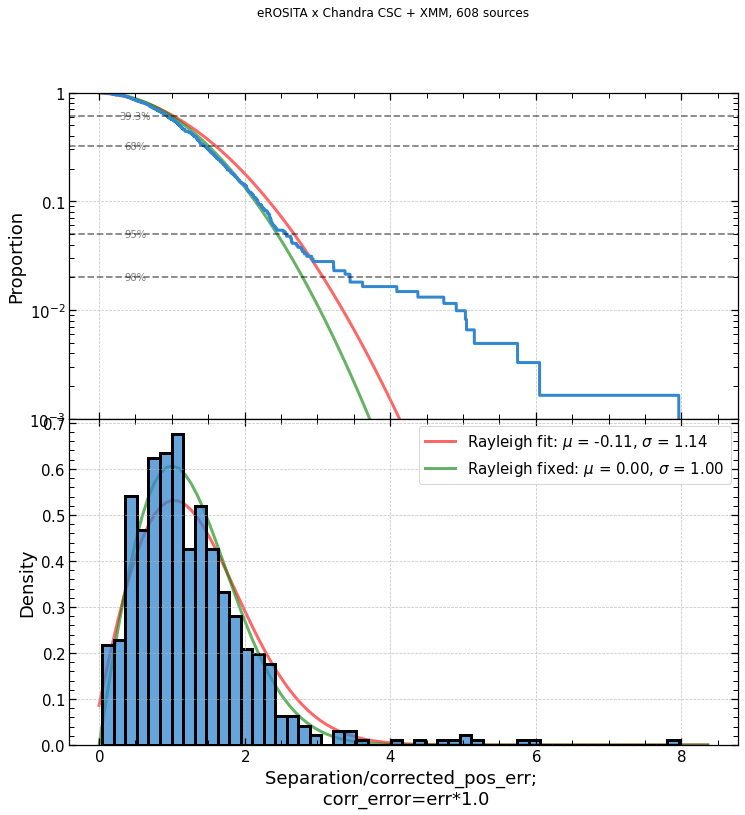

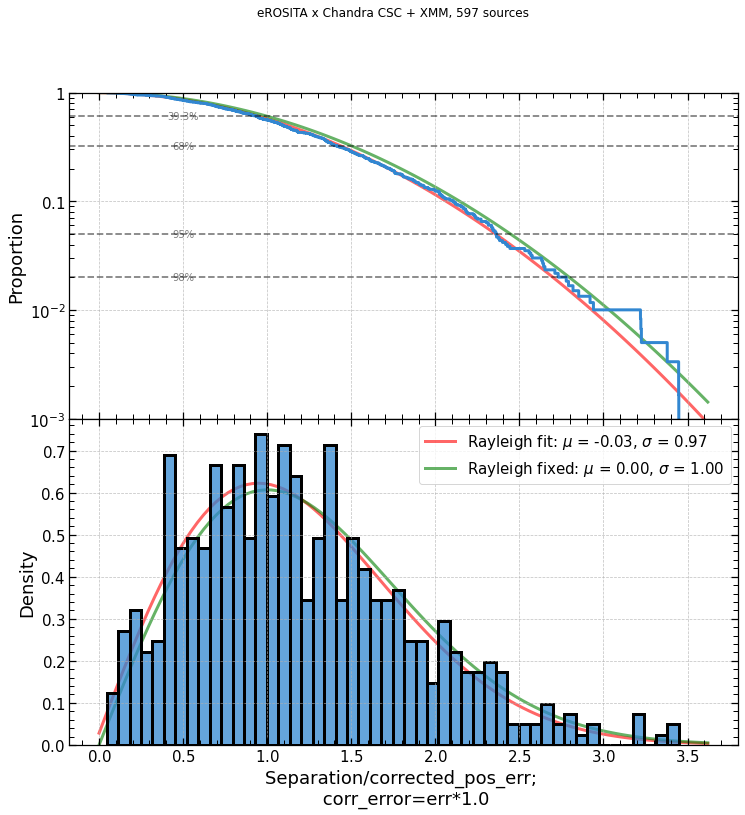

In [21]:
from scripts.cross_match_scripts import rayleigh_plot
rayleigh_plot(final_ctps, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')
rayleigh_plot(final_ctps_cut, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')



In [764]:
# old_companions = pd.read_pickle(data_path+'validation_ctps_ero_desi_lh.pkl')
# old_companions.ID = old_companions.ID.str.decode('utf-8')
# old_companions.desi_id_true_ctp = old_companions.desi_id_true_ctp.str.decode('utf-8')
# old_companions.rename(columns = {'ID':'srcname_fin', 'desi_id_true_ctp': 'desi_id'}, inplace = True)

# old_companions.sort_values(by='srcname_fin', inplace=True)
# old_companions.reset_index(drop=True, inplace=True)
# old_companions = old_companions[old_companions.desi_id!='hostless']

# # old_companions = old_companions.merge(desi[['ra', 'dec', 'desi_id']], on='desi_id', how='left')

# # old_companions = old_companions.merge(ero_df[['RA_fin', 'DEC_fin', 'pos_sigma_2d', 'srcname_fin']], on='srcname_fin', how='left')

# # old_companions = add_separation_columns(old_companions, colname_ra1 = 'RA_fin', colname_dec1 = 'DEC_fin', colname_ra2 = 'ra', colname_dec2 = 'dec', colname = 'sep_ero_desi')

# # old_companions

# # from scripts.cross_match_scripts import rayleigh_plot
# # rayleigh_plot(old_companions, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='old validation cat', pos_err_corr_func=lambda x: 0.9*x)
